In [75]:
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt

In [76]:
def display_image(image, title):
    plt.figure(figsize=(10, 5))
    plt.imshow(image)
    plt.title(title)
    plt.axis("off")
    plt.show()

def display_gray_image(image, title):
    plt.figure(figsize=(10, 5))
    plt.imshow(image, cmap='gray')
    plt.title(title)
    plt.axis("off")
    plt.show()

In [77]:
image_paths = ['assets/stitching/shanghai-21.png', 'assets/stitching/shanghai-22.png', 'assets/stitching/shanghai-23.png']

gray_imgs_bonus = []
for path in image_paths:
    gray_imgs_bonus.append(cv.imread(path, cv.IMREAD_GRAYSCALE))


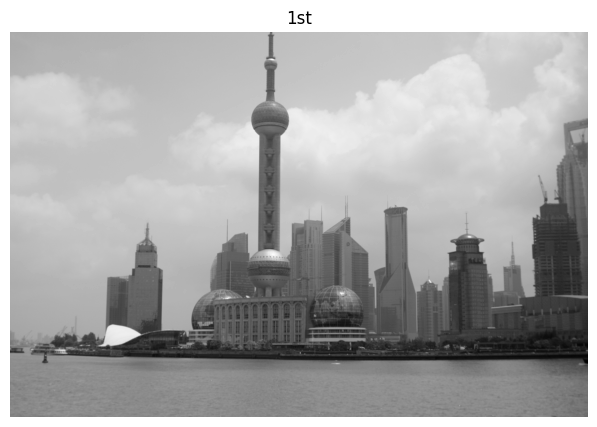

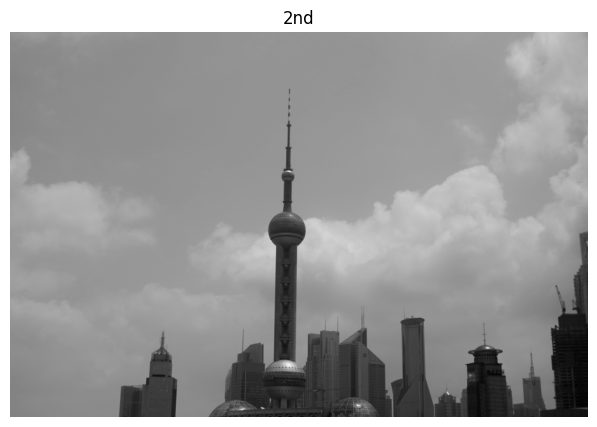

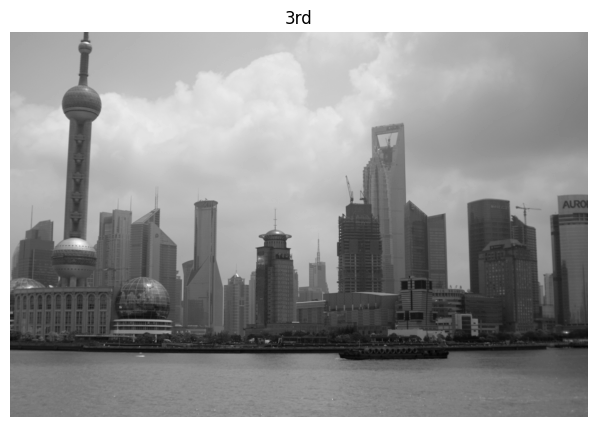

In [78]:
display_gray_image(gray_imgs_bonus[0], "1st")
display_gray_image(gray_imgs_bonus[1], "2nd")
display_gray_image(gray_imgs_bonus[2], "3rd")

In [79]:
sift = cv.SIFT_create()
kp1, des1 = sift.detectAndCompute(gray_imgs_bonus[0], None) #SIFT works best on grayscale images
kp2, des2 = sift.detectAndCompute(gray_imgs_bonus[1], None)
img1 = cv.drawKeypoints(gray_imgs_bonus[0], kp1, gray_imgs_bonus[0].copy(), flags=cv.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
img2 = cv.drawKeypoints(gray_imgs_bonus[1], kp2, gray_imgs_bonus[1].copy(), flags=cv.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

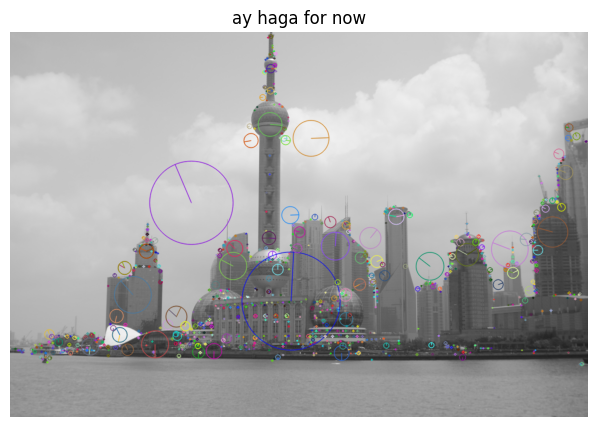

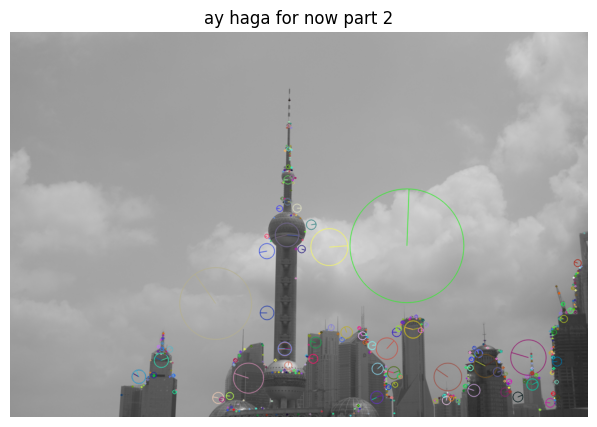

In [80]:
display_image(img1, "ay haga for now")
display_image(img2, "ay haga for now part 2")

In [81]:
bf = cv.BFMatcher()
matches = bf.knnMatch(des1,des2,k=2)

In [82]:
good = []
for m,n in matches:
    if m.distance < 0.5*n.distance:
        good.append([m])

good = sorted(good, key=lambda x: x[0].distance)[:50]

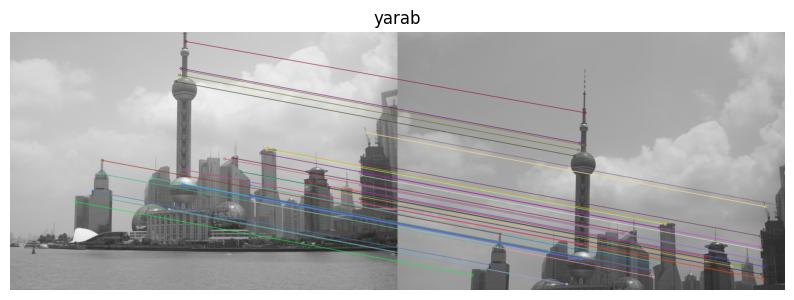

In [83]:
img3 = cv.drawMatchesKnn(gray_imgs_bonus[0],kp1,gray_imgs_bonus[1],kp2,good,None,flags=cv.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
display_image(img3, "yarab")

In [84]:
def compute_homography_manual(good_matches, kp1, kp2):
    src_pts = np.float32([kp1[m[0].queryIdx].pt for m in good_matches])
    dst_pts = np.float32([kp2[m[0].trainIdx].pt for m in good_matches])

    A = []
    for i in range(len(src_pts)):
        x, y = src_pts[i]
        x_prime, y_prime = dst_pts[i]
        A.append([-x, -y, -1,  0,  0, 0, x * x_prime, y * x_prime, x_prime])
        A.append([ 0,  0, 0, -x, -y, -1, x * y_prime, y * y_prime, y_prime])

    A = np.array(A)

    # Ab = 0 -> SVD stuff
    _, _, Vt = np.linalg.svd(A)
    H = Vt[-1].reshape(3, 3)

    # normalize so  H[2,2] = 1
    H = H / H[2, 2]

    return H, src_pts.reshape(-1, 1, 2), dst_pts.reshape(-1, 1, 2)

In [85]:
H, src_pts, dst_pts = compute_homography_manual(good, kp1, kp2)
print("Manual Homography Matrix:\n", H)


Manual Homography Matrix:
 [[ 9.73190696e-01 -3.82548448e-02  4.04593812e+01]
 [-2.80722083e-03  9.54257311e-01  1.97732691e+02]
 [-1.16974457e-05 -6.23882926e-05  1.00000000e+00]]


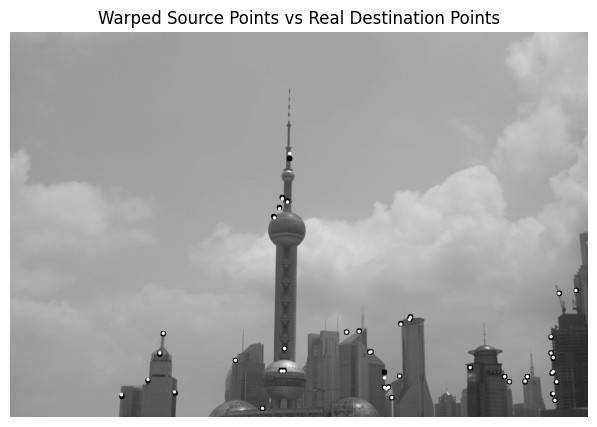

In [86]:
warped_pts = cv.perspectiveTransform(src_pts, H)
img2_verify = gray_imgs_bonus[1].copy()
for pt in warped_pts:
    cv.circle(img2_verify, tuple(np.round(pt[0]).astype(int)), 5, (0, 255, 0), -1)
for pt in dst_pts:
    cv.circle(img2_verify, tuple(np.round(pt[0]).astype(int)), 3, (255, 0, 0), -1)
display_gray_image(img2_verify, "Warped Source Points vs Real Destination Points")


In [100]:
def warp_images(img1, img2, H):
    h1, w1 = img1.shape[:2]
    h2, w2 = img2.shape[:2]
    corners_img1 = np.float32([[0,0],[0,h1],[w1,h1],[w1,0]]).reshape(-1,1,2)
    warped_corners = cv.perspectiveTransform(corners_img1, H)
    corners_img2 = np.float32([[0,0],[0,h2],[w2,h2],[w2,0]]).reshape(-1,1,2)

    all_corners = np.concatenate((warped_corners, corners_img2), axis=0)
    [xmin, ymin] = np.int32(all_corners.min(axis=0).ravel() - 0.5)
    [xmax, ymax] = np.int32(all_corners.max(axis=0).ravel() + 0.5)

    translation = [-xmin, -ymin]
    H_translation = np.array([[1, 0, translation[0]],
                              [0, 1, translation[1]],
                              [0, 0, 1]])

    result = cv.warpPerspective(img1, H_translation.dot(H), (xmax - xmin, ymax - ymin))
    result[translation[1]:translation[1]+h2, translation[0]:translation[0]+w2] = img2

    return result



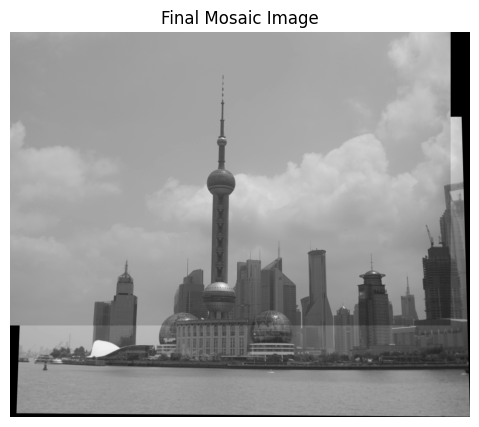

In [101]:
mosaic = warp_images(gray_imgs_bonus[0], gray_imgs_bonus[1], H)
display_gray_image(mosaic, "Final Mosaic Image")

----------------------------------------------------
ADDING 3rd ONE

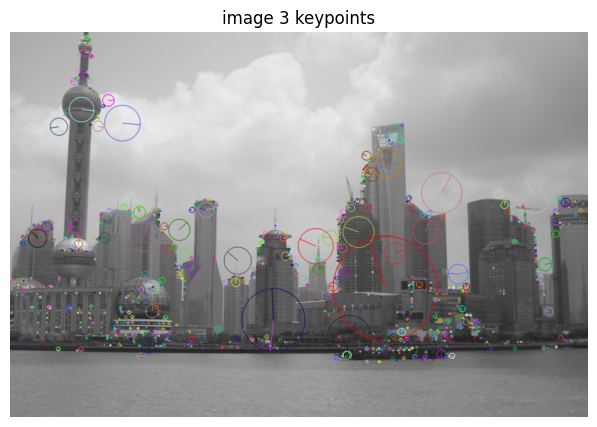

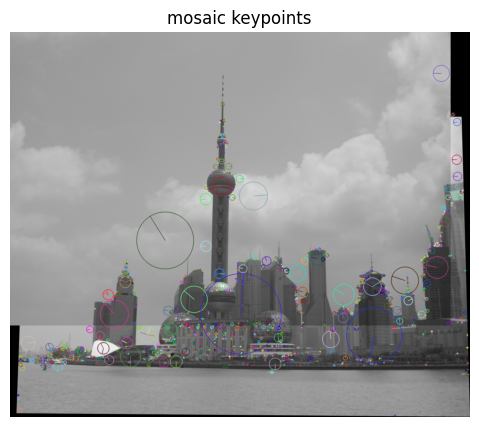

In [89]:
kp21, des21 = sift.detectAndCompute(gray_imgs_bonus[2], None) 
kp22, des22 = sift.detectAndCompute(mosaic, None)

img21 = cv.drawKeypoints(gray_imgs_bonus[2], kp21, gray_imgs_bonus[2].copy(), flags=cv.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
img22 = cv.drawKeypoints(mosaic, kp22, mosaic.copy(), flags=cv.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

display_gray_image(cv.drawKeypoints(gray_imgs_bonus[2], kp21, None, flags=cv.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS), "image 3 keypoints")
display_gray_image(cv.drawKeypoints(mosaic, kp22, None, flags=cv.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS), "mosaic keypoints")


In [90]:
bf = cv.BFMatcher()
matches2 = bf.knnMatch(des21,des22,k=2)

In [91]:
good2 = []
for m,n in matches2:
    if m.distance < 0.5*n.distance:
        good2.append([m])

good2 = sorted(good2, key=lambda x: x[0].distance)[:50]

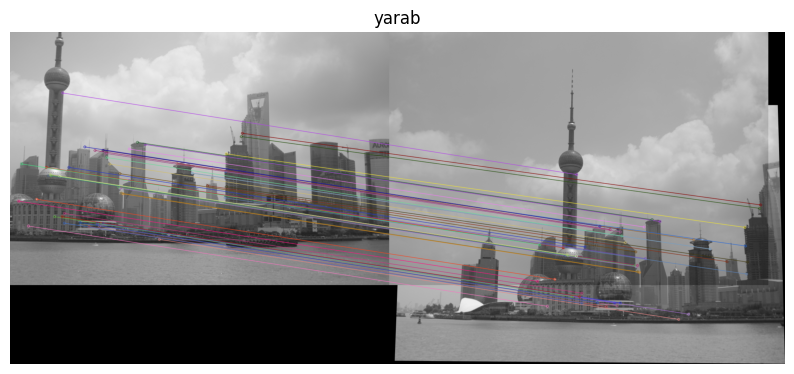

In [92]:
img23 = cv.drawMatchesKnn(gray_imgs_bonus[2],kp21,mosaic,kp22,good2,None,flags=cv.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
display_image(img23, "yarab")

# so far so good

1. built in homography trial first

In [93]:
def get_homography(good, kp1, kp2):
    src_pts = np.float32([kp1[m[0].queryIdx].pt for m in good]).reshape(-1,1,2)
    dst_pts = np.float32([kp2[m[0].trainIdx].pt for m in good]).reshape(-1,1,2)
    H, _ = cv.findHomography(src_pts, dst_pts, cv.RANSAC)
    return H, src_pts, dst_pts

H21, src_pts21, dst_pts21 = get_homography(good2, kp21, kp22)
print("Homography Matrix:\n", H21)



Homography Matrix:
 [[ 8.62299269e-01 -2.00764963e-02  3.73023694e+02]
 [-9.49565963e-02  8.92956966e-01  2.40503655e+02]
 [-1.13904150e-04 -8.54138047e-05  1.00000000e+00]]


2. manual homography

In [94]:
H22, src_pts22, dst_pts22 = compute_homography_manual(good2, kp21, kp22)
print("Manual Homography Matrix:\n", H22)


Manual Homography Matrix:
 [[ 8.59631941e-01 -1.68697122e-02  3.72735086e+02]
 [-9.82287383e-02  8.99233944e-01  2.39283636e+02]
 [-1.17759361e-04 -8.09651092e-05  1.00000000e+00]]


almost same output matrix

In [95]:
# see the reason why this can't be 3shan mesh fakra
# warped_pts = cv.perspectiveTransform(src_pts22, H22)
# img2_verify = gray_imgs_bonus[2].copy()
# for pt in warped_pts:
#     cv.circle(img2_verify, tuple(np.round(pt[0]).astype(int)), 5, (0, 255, 0), -1)
# for pt in dst_pts:
#     cv.circle(img2_verify, tuple(np.round(pt[0]).astype(int)), 3, (255, 0, 0), -1)
# display_gray_image(img2_verify, "Warped Source Points (Green) vs Real Destination Points (Blue)")


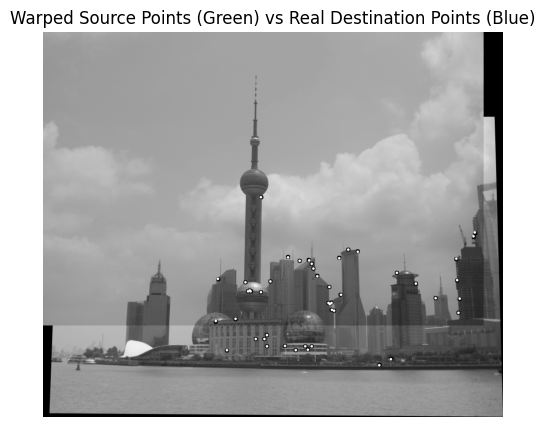

In [96]:
warped_pts = cv.perspectiveTransform(src_pts22, H22)
img2_verify = mosaic.copy()
for pt in warped_pts:
    cv.circle(img2_verify, tuple(np.round(pt[0]).astype(int)), 5, (0, 255, 0), -1)
for pt in dst_pts22:
    cv.circle(img2_verify, tuple(np.round(pt[0]).astype(int)), 3, (255, 0, 0), -1)
display_gray_image(img2_verify, "Warped Source Points (Green) vs Real Destination Points (Blue)")


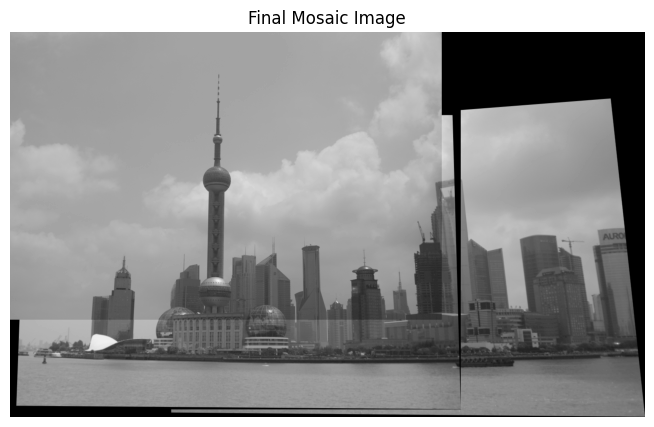

In [119]:

def warp_images(img1, img2, H):
    h1, w1 = img1.shape[:2]
    h2, w2 = img2.shape[:2]
    corners_img1 = np.float32([[0,0],[0,h1],[w1,h1],[w1,0]]).reshape(-1,1,2)
    warped_corners = cv.perspectiveTransform(corners_img1, H)
    corners_img2 = np.float32([[0,0],[0,h2],[w2,h2],[w2,0]]).reshape(-1,1,2)

    all_corners = np.concatenate((warped_corners, corners_img2), axis=0)
    [xmin, ymin] = np.int32(all_corners.min(axis=0).ravel() - 0.5)
    [xmax, ymax] = np.int32(all_corners.max(axis=0).ravel() + 0.5)

    translation = [-xmin, -ymin]
    H_translation = np.array([[1, 0, translation[0]],
                              [0, 1, translation[1]],
                              [0, 0, 1]])

    result = cv.warpPerspective(img1, H_translation.dot(H), (xmax - xmin, ymax - ymin))
    result[translation[1]:translation[1]+h2, translation[0]:translation[0]+w2] = img2

    return result

mosaic2 = warp_images(gray_imgs_bonus[2], mosaic, H22)
# mosaic2 = warp_images(mosaic, gray_imgs_bonus[2], H22)
display_gray_image(mosaic2, "Final Mosaic Image")


trying to remove the black spots

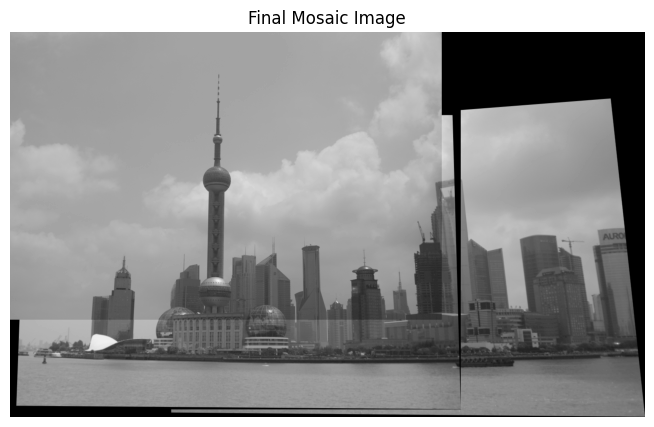

In [123]:
def warp_images(img1, img2, H):
    h1, w1 = img1.shape[:2]
    h2, w2 = img2.shape[:2]

    # Compute corners and warped corners
    corners_img1 = np.float32([[0,0],[0,h1],[w1,h1],[w1,0]]).reshape(-1,1,2)
    warped_corners = cv.perspectiveTransform(corners_img1, H)
    corners_img2 = np.float32([[0,0],[0,h2],[w2,h2],[w2,0]]).reshape(-1,1,2)

    # Combine corners to get the bounding box of both images
    all_corners = np.concatenate((warped_corners, corners_img2), axis=0)
    [xmin, ymin] = np.int32(all_corners.min(axis=0).ravel() - 0.5)
    [xmax, ymax] = np.int32(all_corners.max(axis=0).ravel() + 0.5)

    # Translation for shifting the images into the visible area
    translation = [-xmin, -ymin]
    H_translation = np.array([[1, 0, translation[0]], [0, 1, translation[1]], [0, 0, 1]])

    # Warp the first image (img1) using the homography matrix
    result = cv.warpPerspective(img1, H_translation.dot(H), (xmax - xmin, ymax - ymin))

    # Now, directly place the second image (img2) on top of the warped first image (result)
    result[translation[1]:translation[1]+h2, translation[0]:translation[0]+w2] = img2

    return result



mosaic2 = warp_images(gray_imgs_bonus[2], mosaic, H22)
display_gray_image(mosaic2, "Final Mosaic Image")


--------------------------------------------------------------------
### **Trying different order**